In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%%capture
!pip install mne


# **READING AND PRE-PROCESSING**

In [3]:
from glob import glob
import os
import mne
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [4]:
all_file_path = glob('/content/gdrive/My Drive/EEG_DATA/*.edf')
print(len(all_file_path))

26


In [5]:
healthy_file_path = [i for i in all_file_path if 'h' in i.split('EEG_DATA/')[1]]
patient_file_path = [i for i in all_file_path if 's' in i.split('EEG_DATA/')[1]]
print(len(healthy_file_path), len(patient_file_path))

13 13


In [6]:
def read_data(file_path):
  data = mne.io.read_raw_edf(file_path, preload=True)
  data.set_eeg_reference()
  data.filter(l_freq=0.5,h_freq=45)
  epochs=mne.make_fixed_length_epochs(data,duration=10,overlap=0.5)
  arr=epochs.get_data()
  return arr

In [7]:
sample_data = read_data(healthy_file_path[0])

Extracting EDF parameters from /content/gdrive/My Drive/EEG_DATA/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 97 events and 2500 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished


In [8]:
sample_data.shape #no of epochs, channels, length of signal

(97, 19, 2500)

In [9]:
%%capture
control_epochs_arr = [read_data(i) for i in healthy_file_path]
patient_epochs_arr = [read_data(i) for i in patient_file_path]

In [10]:
control_epochs_arr[2].shape

(97, 19, 2500)

In [11]:

control_epochs_labels = [len(i)*[0] for i in control_epochs_arr]
patient_epochs_labels = [len(i)*[1] for i in patient_epochs_arr]
len(control_epochs_labels),len(patient_epochs_labels)

(13, 13)

In [12]:
data_list = control_epochs_arr+patient_epochs_arr
label_list = control_epochs_labels+patient_epochs_labels

In [13]:
group_list = [[i]*len(j) for i,j in enumerate(data_list)]
len(group_list)

26

In [14]:
len(data_list[0])

97

In [15]:
np.hstack(([0,0],[1,1]))

array([0, 0, 1, 1])

In [16]:
data_arr = np.vstack(data_list)
label_arr = np.hstack(label_list)
group_arr =np.hstack(group_list)
data_arr.shape, label_arr.shape,group_arr.shape

((2699, 19, 2500), (2699,), (2699,))

In [17]:
label_arr

array([0, 0, 0, ..., 1, 1, 1])

# **CNN**

In [ ]:
epochs_arr = np.moveaxis(data_arr,1,2)
epochs_arr.shape

(2699, 2500, 19)

In [28]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model



In [ ]:
def cnnmodel():
  clear_session()
  model=Sequential()
  model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(1250,19)))#1
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))#2
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))#4
  model.add(Dropout(0.5))
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))#6
  model.add(Dropout(0.5))
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))#8
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
  model.add(LeakyReLU())
  model.add(GlobalAveragePooling1D())#10
  model.add(Dense(1,activation='sigmoid'))#11

  model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model
model=cnnmodel()
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 5)           290       
                                                                 
 batch_normalization (BatchN  (None, 1248, 5)          20        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1248, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 624, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 622, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 622, 5)            0

In [ ]:
plot_model(model, to_file="my_model.png", show_shapes=True)

In [ ]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

gkf=GroupKFold()


In [ ]:
accuracy=[]
#model=cnnmodel()
for train_index,val_index in gkf.split(epochs_arr,label_arr,groups=group_arr):
  train_features,train_labels = epochs_arr[train_index],label_arr[train_index]
  val_features,val_labels = epochs_arr[val_index],label_arr[val_index]

  scaler =  StandardScaler()
  train_features=scaler.fit_transform(train_features.reshape(-1,\
                    train_features.shape[-1])).reshape(train_features.shape)
  val_features=scaler.transform(val_features.reshape(-1,\
                    val_features.shape[-1])).reshape(val_features.shape)

  
  #model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))
  #accuracy.append(model.evaluate(val_features,val_labels)[1])
  break


In [ ]:
train_features.shape

In [ ]:
np.mean(accuracy)

# **ChronoNet**

In [ ]:
import torch.nn as nn
import torch
input = torch.randn(3,22,15000)
input.shape

torch.Size([3, 22, 15000])

In [ ]:
nn.Conv1d(in_channels=22,out_channels=32,kernel_size=2,stride=2,padding=0)

Conv1d(22, 32, kernel_size=(2,), stride=(2,))

In [ ]:
class Block(nn.Module):
  def __init__(self, inplace):
    super().__init__()
    self.conv1 = nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=2,stride=2,padding=0)
    self.conv2 = nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=8,stride=2,padding=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    x1 = self.conv1(x)
    x2 = self.conv2(x)
    x3 = self.conv3(x)
    x = torch.cat([x1,x2,x3],dim=1)
    return x

In [ ]:
block = Block(22)
out1 = block(input)
out1.shape

torch.Size([3, 96, 7500])

In [ ]:
block = Block(96)
out2 = block(out1)
out2.shape

torch.Size([3, 96, 3750])

In [ ]:
block = Block(96)
out3 = block(out2)
out3.shape

torch.Size([3, 96, 1875])

In [ ]:
gru = nn.GRU(input_size=96,
hidden_size=32,batch_first=True)
x = out3.permute(0,2,1)
x.shape


torch.Size([3, 1875, 96])


# **ChroNet Keras**

In [29]:
epochs_arr = np.moveaxis(data_arr,1,2)
epochs_arr.shape
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

gkf=GroupKFold()
for train_index,val_index in gkf.split(epochs_arr,label_arr,groups=group_arr):
  train_features,train_labels = epochs_arr[train_index],label_arr[train_index]
  val_features,val_labels = epochs_arr[val_index],label_arr[val_index]

  scaler =  StandardScaler()
  train_features=scaler.fit_transform(train_features.reshape(-1,\
                    train_features.shape[-1])).reshape(train_features.shape)
  val_features=scaler.transform(val_features.reshape(-1,\
                    val_features.shape[-1])).reshape(val_features.shape)
  break
train_features.shape

(2099, 2500, 19)

In [30]:
val_labels.shape


(600,)

In [31]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model

In [32]:
def block(input):
  conv1 = Conv1D(filters=32,kernel_size=2,strides=2,activation='relu',padding='causal')(input)
  conv2 = Conv1D(filters=32,kernel_size=4,strides=2,activation='relu',padding='causal')(input)
  conv3 = Conv1D(filters=32,kernel_size=8,strides=2,activation='relu',padding='causal')(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

In [33]:
input = Input(shape=(2500, 19))
block1 = block(input)
block1.shape

TensorShape([None, 1250, 96])

In [34]:
block2 = block(block1)
block3 = block(block2)
block3.shape

TensorShape([None, 313, 96])

In [35]:
gru1 = GRU(units=32,return_sequences=True)(block3)
gru2 = GRU(units=32,return_sequences=True)(gru1)
gru_out = concatenate([gru1,gru2],axis=2)

gru3 = GRU(units=32,return_sequences=True)(gru_out)
gru_out = concatenate([gru1,gru2,gru3],axis=2)
gru_out.shape

TensorShape([None, 313, 96])

In [36]:
gru4 = GRU(units=32)(gru_out)
out2 = Dense(16,activation='relu')(gru4)
out = Dense(1,activation='sigmoid')(out2)

In [37]:
model = Model(inputs=input,outputs=out)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

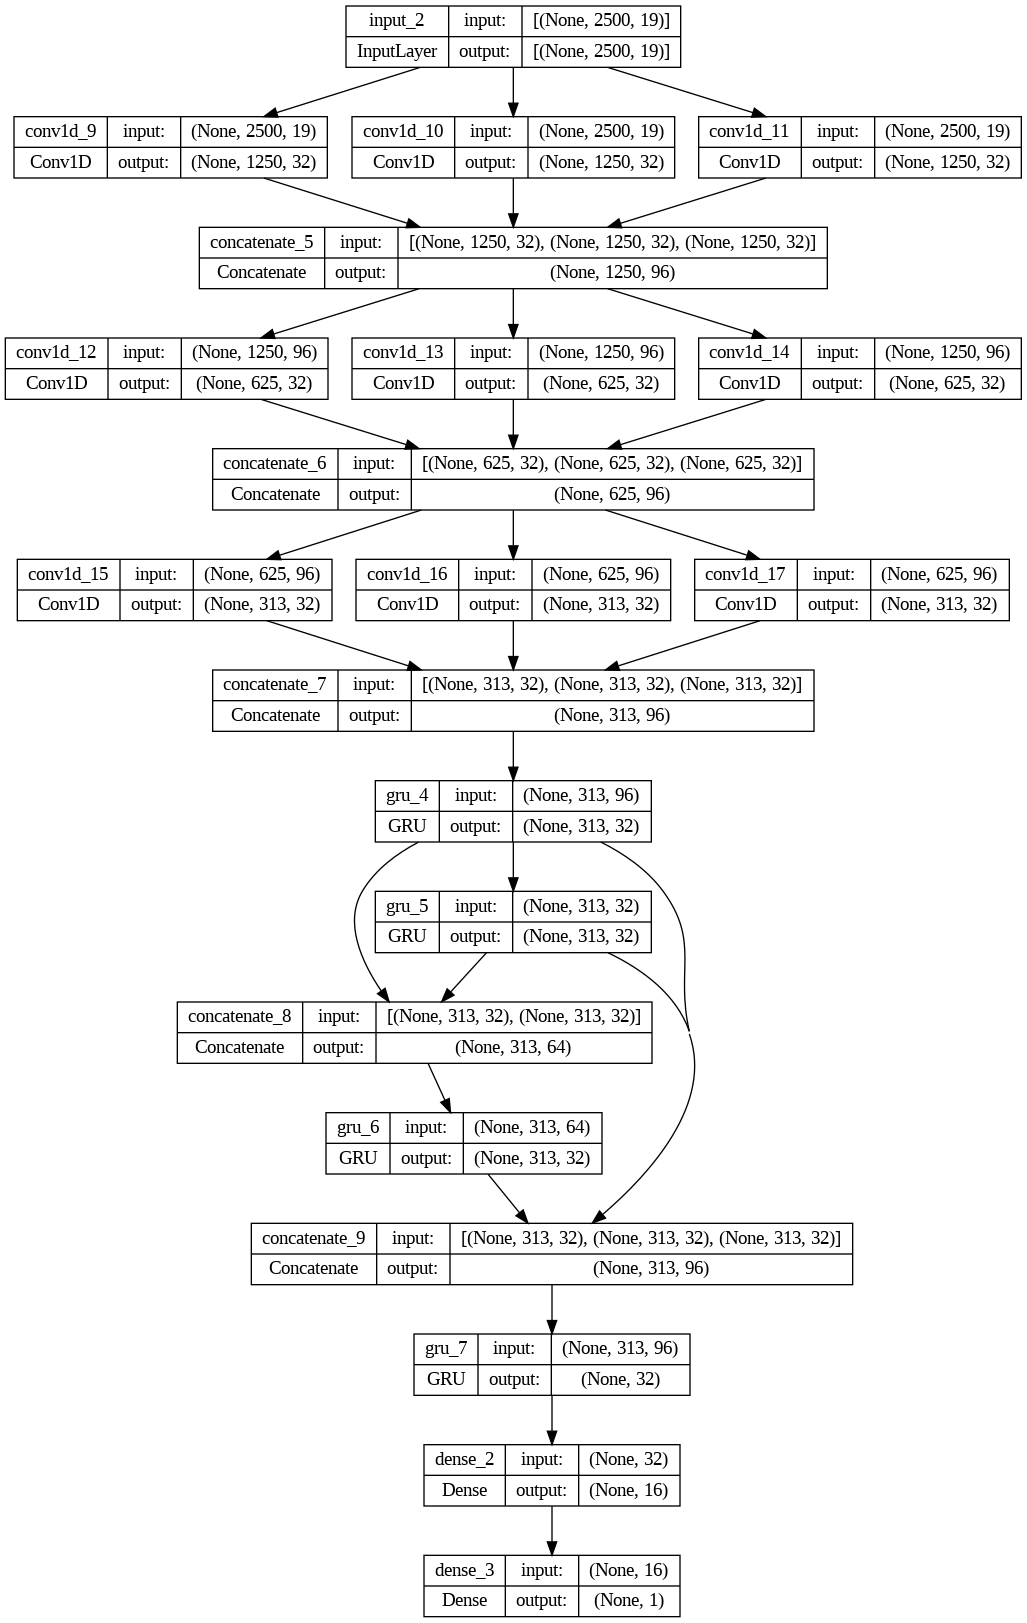

In [38]:
plot_model(model, to_file="my_model.png", show_shapes=True)

In [39]:
model.fit(train_features,train_labels,epochs=20,batch_size=128,validation_data=(val_features,val_labels))

Epoch 1/20
17/17 [==============================] - 27s 265ms/step - loss: 0.6810 - accuracy: 0.5517 - val_loss: 0.6718 - val_accuracy: 0.6050
Epoch 2/20
17/17 [==============================] - 2s 108ms/step - loss: 0.5757 - accuracy: 0.7089 - val_loss: 0.6210 - val_accuracy: 0.7000
Epoch 3/20
17/17 [==============================] - 2s 103ms/step - loss: 0.3916 - accuracy: 0.8328 - val_loss: 0.7116 - val_accuracy: 0.6917
Epoch 4/20
17/17 [==============================] - 2s 113ms/step - loss: 0.2360 - accuracy: 0.9119 - val_loss: 1.1243 - val_accuracy: 0.6217
Epoch 5/20
17/17 [==============================] - 2s 116ms/step - loss: 0.1190 - accuracy: 0.9638 - val_loss: 1.7153 - val_accuracy: 0.5400
Epoch 6/20
17/17 [==============================] - 2s 115ms/step - loss: 0.2123 - accuracy: 0.9209 - val_loss: 0.7709 - val_accuracy: 0.7300
Epoch 7/20
17/17 [==============================] - 2s 102ms/step - loss: 0.0764 - accuracy: 0.9771 - val_loss: 1.0095 - val_accuracy: 0.7183
Epoch

In [ ]:
model.evaluate(val_features,val_labels,verbose=0)

[1.0453910827636719, 0.8100000023841858]

In [ ]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [52]:
file_path = glob('/content/gdrive/My Drive/EEG_DATA/TEST/*.edf')
test_path = [i for i in file_path if 's' in i.split('EEG_DATA/TEST')[1]]
#print(test)
test=read_data(test_path[0])
test =np.moveaxis(test,1,2)
test=scaler.fit_transform(test.reshape(-1,\
                    test.shape[-1])).reshape(test.shape)
test.shape[0]
out = model.predict(test)
pred = [ 1 if x>0.3 else 0 for x in out ]
#np.sum(model.predict(test))


Extracting EDF parameters from /content/gdrive/My Drive/EEG_DATA/TEST/s14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 542499  =      0.000 ...  2169.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 228 events and 2500 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s finished


8/8 [==============================] - 0s 32ms/step


In [ ]:
pred

# **ResNet**


In [42]:
%%capture
!pip install ssqueezepy
!pip install timm
!pip install pytorch-lighting

In [43]:
data_arr.shape, label_arr.shape,group_arr.shape

((2699, 19, 2500), (2699,), (2699,))

In [44]:
#!mkdir '/content/gdrive/My Drive/EEG_DATA/scaleogram'
!mkdir '/content/scaleogram'

In [45]:
import scipy.io
import torch.nn as nn
import torch
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import os
from scipy.signal import hann

In [46]:
Wx, scales = cwt(data_arr[0], 'morlet')

In [47]:
Wx.shape

(19, 246, 2500)

In [48]:
f"{label_arr[0]:04d}"

'0000'

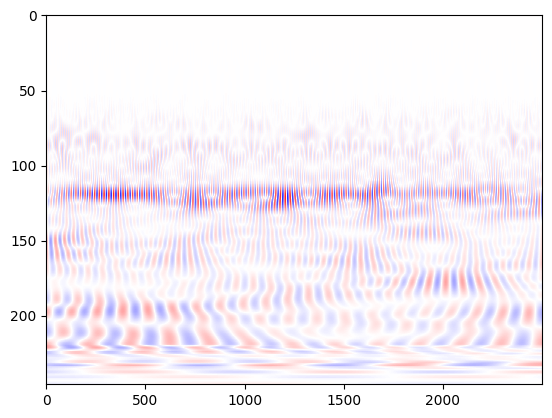

In [49]:
imshow(Wx[0])

In [ ]:
for i,data in enumerate(data_arr):
  Wx, scales = cwt(data, 'morlet')
  Wx = np.abs(Wx)
  path = os.path.join('/content/scaleogram',f'data_{i:04d}_{label_arr[i]}')
  #os.makedirs(path,exist_ok=True)
  np.save(path,Wx)
  print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: ignored

In [ ]:
glob('/content/*')

['/content/gdrive', '/content/sample_data']

In [ ]:
!rm -r '/content/scaleogram'